## Pedagogical agents using LLM

To create a pedagogical agent using LLM, we need three basic things:
1. A vector database/Index from knowledge base
2. A LLM model
3. A good prompt/question asking

### Create a new virtual environment
- Go to the project folder
- python3 -m venv Pagent
- ./Pagent/Scripts/activate

### Vector Database
We directly use Gemini to process our data. Model can process upto 1 million tokens(~700k words or  50,000 lines of code with the standard 80 characters per line). This is roughly 2000 pages.

### Importing necessary libraries

In [1]:
import os             # Provides functions to interact with the operating system
import time           # Allows for time-related functions, including delays
import glob           # Enables file pattern matching (e.g., finding all files with a certain extension)
import google.generativeai as genai  # Imports Google’s generative AI library for accessing generative AI functions
from dotenv import load_dotenv      # Handles environment variables by loading from a .env file
from google.generativeai.types import HarmCategory, HarmBlockThreshold  # Allows for setting harm categories and block thresholds
from IPython.display import Image

# Loading environment variables from the .env file
load_dotenv()

/opt/anaconda3/envs/agent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### GenAI Access and Initializing Core Variables

In [2]:
# Configuring Google Generative AI with the API key from environment variables
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# Initializing key variables for later use
model = None               # Placeholder for the generative AI model instance
safety_settings = None     # Placeholder for safety settings to manage response sensitivity
files = None               # Placeholder for file handling, such as for file upload or processing
chat_session = None        # Placeholder for managing a chat session with the AI model
cached_responses = {}      # Dictionary to store previously generated responses for faster access


### Get API key

To use Gemini first get an API key​

- Search “makersuit google.com” or​ | Visit: https://aistudio.google.com/app/apikey​

- Login to your Gmail account (if necessary)​

- Click “Get API key”​

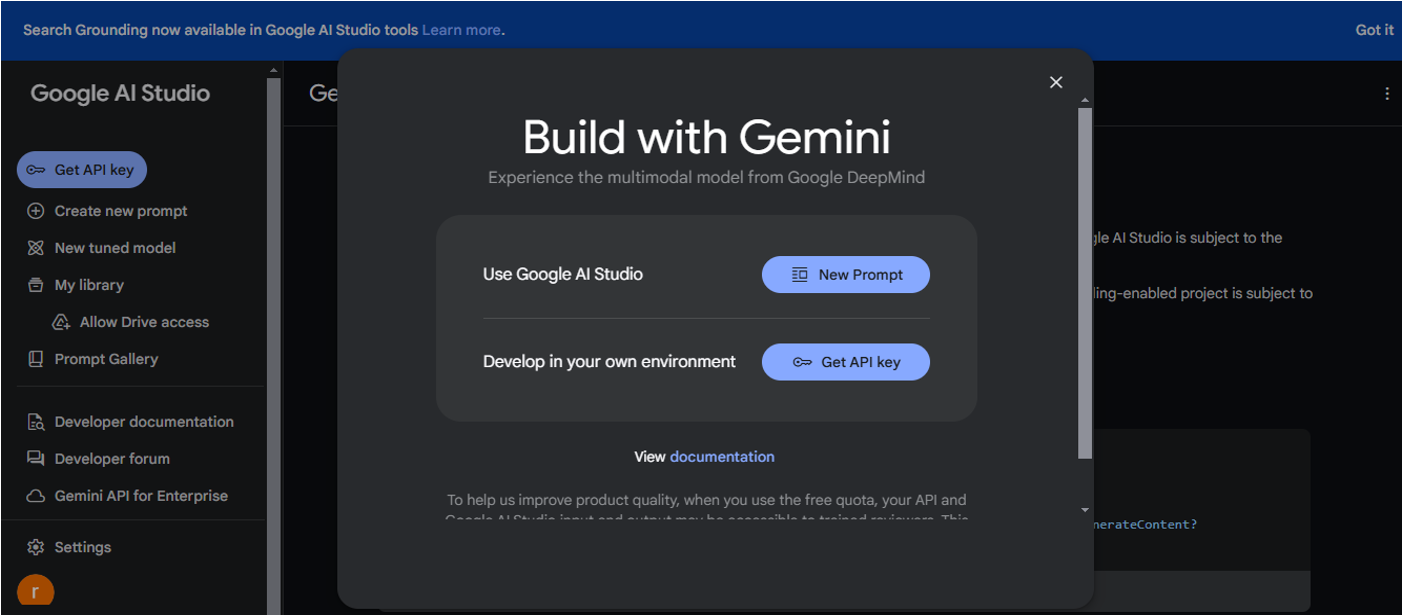

In [3]:
Image(filename='./images/get_api.png')

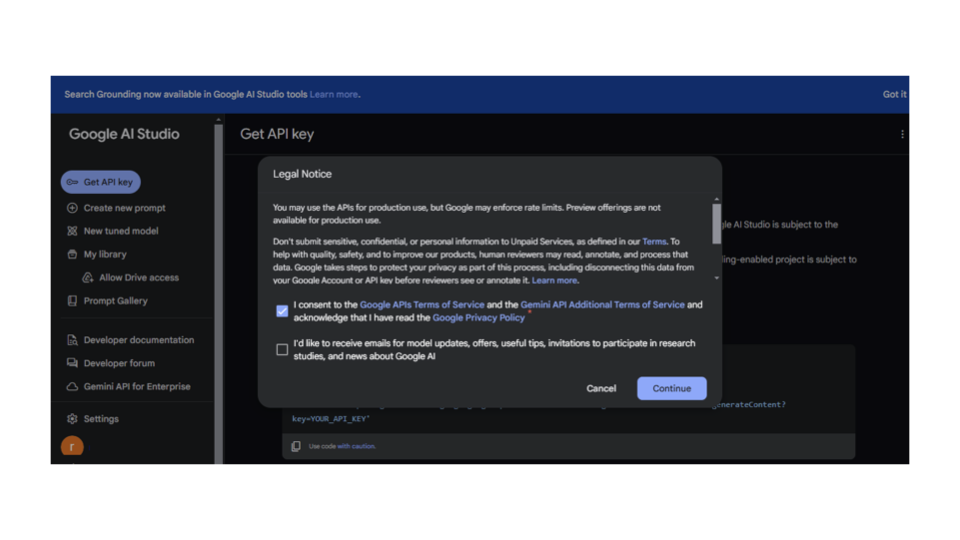

In [4]:
Image(filename='./images/get_api_2.png')

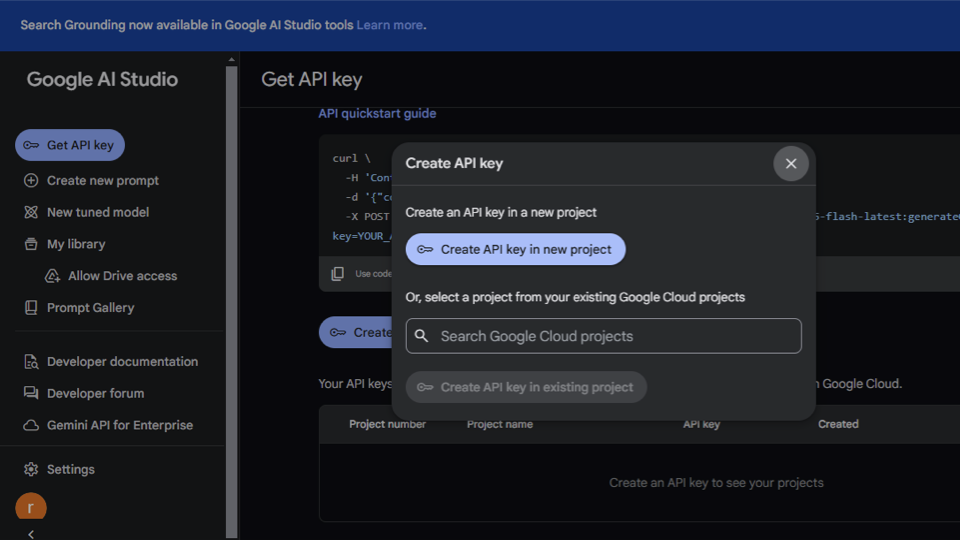

In [5]:
Image(filename='./images/get_api_3.png')

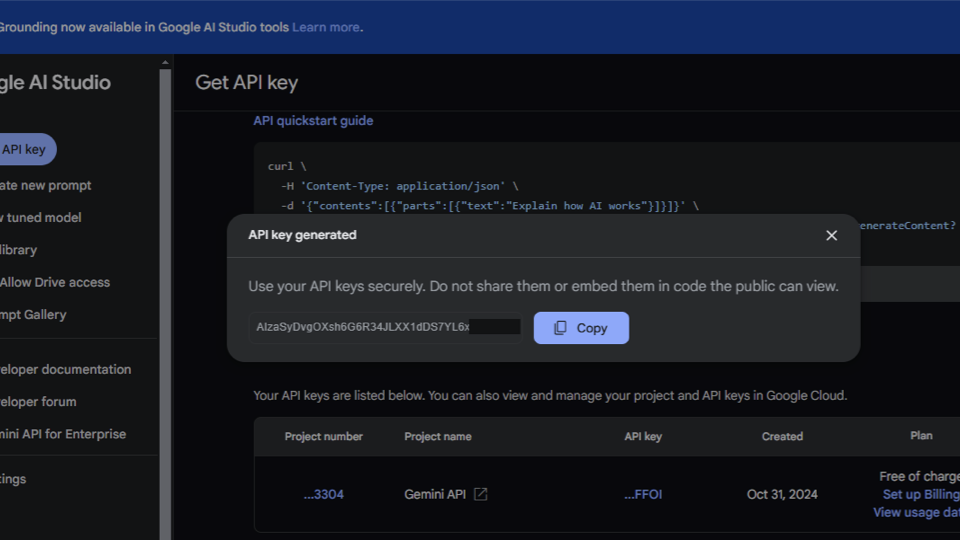

In [6]:
Image(filename='./images/get_api_4.png')

### Prepare Resource and Model

In [7]:
def upload_to_gemini(paths, mime_type=None):
    """
    Uploads specified files to the Gemini platform.

    Parameters:
    - paths (list): List of file paths to upload.
    - mime_type (str, optional): The MIME type of the files (e.g., "application/pdf").
                                 If None, the MIME type defaults to the file type.

    Returns:
    - files (list): A list of uploaded file objects, each containing metadata like display name and URI.

    Workflow:
    1. Iterates over each file path in `paths`.
    2. Uploads the file to Gemini using `genai.upload_file()`.
    3. Prints a confirmation message with the file's display name and URI after a successful upload.
    4. Appends each uploaded file to the `files` list, which is returned at the end.
    """
    
    files = []
    for path in paths:
        # Upload each file to the generative AI platform, specifying MIME type if provided
        file = genai.upload_file(path, mime_type=mime_type)
        
        # Print confirmation of each uploaded file
        print(f"Uploaded file '{file.display_name}' as: {file.uri}")
        
        # Add the uploaded file object to the files list
        files.append(file)
    
    return files


In [8]:
def wait_for_files_active(files):
    """
    Waits for each uploaded file to complete processing and become active on the Gemini platform.

    Parameters:
    - files (list): List of uploaded file objects to check for active status.

    Workflow:
    1. Displays a message to indicate waiting for file processing.
    2. For each file in `files`, checks its processing state on the Gemini platform.
    3. Repeatedly queries the file's state every 10 seconds until it becomes "ACTIVE".
    4. Raises an exception if a file fails to reach the "ACTIVE" state, indicating a processing error.
    5. Once all files are active, prints a success message.

    Raises:
    - Exception: If any file fails to process and reach the "ACTIVE" state.
    """
    
    print("Waiting for file processing...")
    for name in (file.name for file in files):
        # Retrieve the current status of the file
        file = genai.get_file(name)
        
        # Check the file status in a loop until it is marked as "ACTIVE"
        while file.state.name == "PROCESSING":
            print(".", end="", flush=True)  # Indicate processing with dots
            time.sleep(10)  # Wait 10 seconds before checking again
            file = genai.get_file(name)
        
        # Raise an error if file processing failed
        if file.state.name != "ACTIVE":
            raise Exception(f"File {file.name} failed to process")
    
    # Success message when all files are ready for use
    print("...all files ready\n")


In [9]:
def configure_genai():
    """
    Configures the generative AI model with safety settings and generation parameters, and starts a chat session.

    Workflow:
    1. Defines safety settings to manage the filtering of specific content categories.
    2. Sets generation configuration parameters for controlling response generation.
    3. Instantiates the `GenerativeModel` with specified settings.
    4. Initializes a chat session with the model for interactive conversations.

    Attributes:
    - safety_settings (dict): Configuration for blocking various content harm categories (e.g., hate speech, harassment).
    - generation_config (dict): Settings that control generation behavior, such as `temperature` and `max_output_tokens`.
    - model (GenerativeModel): The generative model instance configured with the specified parameters.
    - chat_session (ChatSession): A chat session object for managing interactions with the model.
    """
    global model, safety_settings, chat_session, generation_config
    # Define safety settings for different types of harmful content
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    }
    
    # Configure generation parameters to control response characteristics
    generation_config = {
        "temperature": 0,              # Determines randomness in generation; 0 means deterministic output
        "top_p": 0.95,                 # Controls cumulative probability for sampling
        "top_k": 64,                   # Limits the sampling pool to the top 64 tokens
        "max_output_tokens": 8192,     # Sets the maximum number of tokens for the generated response
        "response_mime_type": "text/plain",  # Specifies response type as plain text
    }
    
    # Initialize the generative AI model with specified settings
    model = genai.GenerativeModel(model_name="gemini-2.0-flash", generation_config=generation_config)
    
    # Start a new chat session for ongoing interactions
    chat_session = model.start_chat()


In [10]:
def load_resources(load_resource=False):
    """
    Loads resource files into the system, specifically uploading PDFs from the 'uSucceed_resource' directory
    to the Gemini AI platform if necessary. 

    Parameters:
    - load_resource (bool): If True, forces re-loading of resource files. Defaults to False.

    Workflow:
    1. Checks if resource files need to be loaded, based on `load_resource` or the existence of `files`.
    2. Uses `glob` to find all PDFs in the specified 'uSucceed_resource' folder.
    3. Calls `upload_to_gemini()` to upload the PDFs to Gemini for further processing.
    4. Invokes `wait_for_files_active()` to ensure all files are uploaded and ready for use.
    5. Configures the generative AI system with `configure_genai()` for effective processing.
    """
    global files
    if load_resource or not files:
        # Retrieve all PDF files in the specified directory
        file_paths = glob.glob("../uSucceed_resource_DDOS/*.pdf")
        
        # Upload files to the generative AI platform with specified MIME type
        files = upload_to_gemini(file_paths, mime_type="application/pdf")
        
        # Ensure the files are active and ready for use
        wait_for_files_active(files)
        
        # Set up the generative AI with any necessary configurations
        configure_genai()


### Model configuration
For any LLM moels, we need a model configuration or model text generation configuration. This actually control models text generation capabilities. <br>
Temperature: controls output generation. For T=0, The model produces deterministic output, meaning it will always generate the same response given the same input. This is for consistency. <br> <br>
But for Gemini, we need one more configuration. which is security parameters. Google is very concerned about their security. So you need to configure the security parameters:
- HATE_SPEECH
- HARASSMENT
- SEXUALLY_EXPLICIT
- DANGEROUS_CONTENT


### Query Type Detection

In [11]:
def detect_query_type(query: str) -> str:
    """
    Detects the type of query based on keywords, helping prioritize relevant documents.

    Parameters:
    - query (str): The user's input question or query.

    Returns:
    - str: A category label for the query type, either 'location', 'cybersecurity', 'system', or 'other'.

    Workflow:
    1. Defines sets of keywords for three categories: location-based, cybersecurity-related, and system-related queries.
    2. Converts the query to lowercase for case-insensitive matching.
    3. Checks if any keywords from each category are present in the query.
    4. Returns the corresponding category if keywords are found, or 'other' if no keywords match.
    """
    
    # Define keyword lists for each query category
    location_keywords = ['room', 'location', 'where', 'place', 'area', 'task', 'server room']
    security_keywords = [
        'security', 'cyber', 'attack', 'threat', 'protection', 'ddos', 'dns', 
        'firewall', 'encryption', 'malware', 'phishing', 'ransomware', 
        'vulnerability', 'penetration', 'breach', 'authentication', 'intrusion',
        'zero-day', 'exploit', 'mitigation', 'defense', 'incident', 'forensics',
        'safety', 'network security', 'data breach', 'password', 'access control'
    ]

    system_keywords = [
        'controller', 'system', 'asset', 'configuration', 'architecture', 
        'setup', 'installation', 'framework', 'protocol', 'integration', 
        'hardware', 'software', 'deployment', 'infrastructure', 'operating system', 
        'network', 'database', 'automation', 'monitoring', 
        'maintenance', 'device', 'tool', 'resource management', 'scalability'
    ]

    
    # Convert query to lowercase for case-insensitive comparison
    query_lower = query.lower()
    
    # Match keywords to categorize the query type
    if any(keyword in query_lower for keyword in location_keywords):
        return 'location'
    elif any(keyword in query_lower for keyword in security_keywords):
        return 'cybersecurity'
    elif any(keyword in query_lower for keyword in system_keywords):
        return 'system'
    
    # Default return for queries that don't match any category
    return 'other'


### Query Processing and Answer Generation

In [12]:
def generate_prompt(query_type: str, query: str) -> str:
    """Generate context-aware prompt based on query type"""
    prompts = {
        'location': """You are a location-aware assistant. For questions about rooms or tasks:
                     1. ONLY use information from 'Rooms_And_Tasks.pdf'
                     2. Ignore all other documents completely for room/task questions
                     3. Provide specific task details for the requested room
                     4. If the information isn't in Rooms_And_Tasks.pdf, say "I cannot find information about this room/task in the available documents."
                     
                     Question: {query}""",
                     
        'cybersecurity': """You are a cybersecurity expert. For security questions:
                           1. Prioritize information from cybersecurity guides and best practices
                           2. Provide specific, actionable security information
                           3. Only include room or system information if directly relevant to security
                           
                           Question: {query}""",
        
        'system': """You are a system configuration assistant. For system questions:
                    1. Focus on technical configuration and asset details
                    2. Reference room information only if relevant to system setup
                    3. Include security considerations only if directly applicable
                    
                    Question: {query}""",
        
        # 'other': """You are a helpful assistant. Please answer the following question:
        #            {query}"""
        # 'other': """You are a helpful assistant. Answer the following question ONLY if the information is found in the provided resources. If the requested information is not available in the resources, respond with: 
        #              "I cannot answer this question based on the available resources."
        #             Question: {query}"""
        'other': f"""You are a helpful assistant. Answer the following question **ONLY if the information is found in the provided resources.**  

        If the requested information is **not available in the provided resources**, respond with:  
        "I cannot answer this question based on the available resources."  

        If the question is a **general knowledge fact or a basic mathematical question that does not require specific resource-based information**, respond with:  
        "I can only answer questions based on the provided resources."  

        Otherwise, provide a relevant and concise response.  

        Question: {query}"""
    }
    
    return prompts[query_type].format(query=query)

In [13]:
# def generate_prompt(query_type: str, query: str) -> str:
#     """Generate context-aware prompt based on query type"""
#     prompts = {
#         'location': """You are a location-aware assistant. For questions about rooms or tasks:
#                      1. Do not include information based on universal truths or unrelated topics. If the requested information is not available in the document, respond with: 
#                        "I cannot find information about this room/task in the available documents."
#                      2. ONLY use information from 'Rooms_And_Tasks.pdf'
#                      3. Ignore all other documents completely for room/task questions
#                      4. Provide specific task details for the requested room
#                      5. If the information isn't in Rooms_And_Tasks.pdf, say "I cannot find information about this room/task in the available documents."
                     
#                      Question: {query}""",
                     
#         'cybersecurity': """You are a cybersecurity expert. For security questions:
#                            1. Avoid using general or universal knowledge that is not explicitly available in the resources. If the information is not in the documents, respond with: 
#                              "I cannot find information about this topic in the available documents."
#                            2. Prioritize information from cybersecurity guides and best practices
#                            3. Provide specific, actionable security information
#                            4. Only include room or system information if directly relevant to security
                           
#                            Question: {query}""",
        
#         'system': """You are a system configuration assistant. For system questions:
#                     1. Do not include information based on universal truths or unrelated topics. If the requested information is not in the documents, respond with: 
#                       "I cannot find information about this system setup in the available documents."
#                     2. Focus on technical configuration and asset details
#                     3. Reference room information only if relevant to system setup
#                     4. Include security considerations only if directly applicable
                    
#                     Question: {query}""",
        
#         'other': """You are a helpful assistant. Answer the following question ONLY if the information is found in the provided documents. If the requested information is not available in the resources, respond with: 
#                      "I cannot answer this question based on the available documents."
#                     Question: {query}"""
#     }
    
#     return prompts[query_type].format(query=query)

### Query processing
We want our system to be able to answer questions both context and content based.
- Rule based classification
- Generate final prompt based on the classification.

In [14]:
def get_answer(query: str):
    """
    Processes a user query, generates an answer using loaded files, 
    and returns the answer along with execution times for various parts of the process.

    Parameters:
    - query (str): The user's question or query that needs to be answered.

    Returns:
    - tuple: A tuple containing the generated answer (str) and a dictionary of execution times (dict).

    Workflow:
    1. Checks if any files are loaded; raises an exception if none are available.
    2. Records the time taken for initial checks.
    3. Checks the cache for previously answered queries to optimize response time.
    4. Detects the type of query (location, cybersecurity, system, etc.) to prioritize relevant documents.
    5. Prepares a prompt for the generative model, including the user's question.
    6. Selects and prioritizes relevant files based on the query type, adjusting the history context accordingly.
    7. Sends the prepared prompt to the chat session and measures the response time.
    8. Caches the generated response for future reference.
    9. Returns the generated answer and timing metrics.
    
    Exception Handling:
    - If an error occurs during processing, it logs the error message along with the time taken until the error occurred.
    """
    
    # Initialize timing dictionary and start overall timing
    timings = {}
    start_time = time.time()
    global history

    try:
        # Ensure files are loaded for processing
        if not files:
            raise Exception("No files loaded. Please load files first using load_files()")
        
        # Record time taken for initial file check
        timings['initial_check'] = time.time() - start_time
        
        # Check cache first to save time on repeated queries
        if query in cached_responses:
            return cached_responses[query], {'cached': True, 'total_time': time.time() - start_time}

        # Prepare the chat context and prompt for the query
        query_type = detect_query_type(query)
        print(f"Detected query type: {query_type}")
        prompt_intro = f"""You are a question answering model. If the requested information is not in the documents, respond with: 'I cannot find information about this system setup in the available documents.' Please Do not answer general knowledge fact or a basic mathematical question that does not require specific resource-based information. Answer the following question briefly and to the point. If there are multiple points found, give them all as it is and list them in a list. The question is:"""
        prompt = prompt_intro + " " + query
        # prompt = generate_prompt(query_type, query)
        
        # Prioritize relevant files for location queries
        relevant_files_start_time = time.time()
        relevant_files = files

        # Separate and prioritize files based on query type
        if query_type == 'location':
            prioritized_files = [file for file in files if 'Rooms_And_Tasks.pdf' in file.display_name]
            other_files = [file for file in files if 'Rooms_And_Tasks.pdf' not in file.display_name]
            relevant_files = prioritized_files + other_files
            
        # Record time taken for relevant files selection
        timings['relevant_files_selection'] = time.time() - relevant_files_start_time
        
        # Optimize the history update to keep full content only in prioritized files
        history = []
        for file in relevant_files:
            if query_type == 'location' and 'Rooms_And_Tasks.pdf' in file.display_name:
                history.append({
                    "role": "user",
                    "parts": [file]  # Full content for prioritized files
                })
            else:
                # Use minimal info for other files
                history.append({
                    "role": "user",
                    "parts": [f"Basic content from {file.display_name}"]
                })
        
        # Add prompt to history
        history.append({
            "role": "user",
            "parts": [prompt]
        })
        
        # Apply history if this is a location query or complex question
        if query_type == 'location':
            chat_session.history = history
        
        # Get response from chat session
        response_start_time = time.time()
        response = chat_session.send_message(prompt, safety_settings=safety_settings)
        
        end_time = time.time()
        timings['response_time'] = end_time - response_start_time  # Time for getting response
        timings['total_time'] = end_time - start_time  # Total time taken
        
        # Cache the response for future queries
        cached_responses[query] = response.text
        
        return response.text, timings  # Return the generated answer and timing breakdown
        
    except Exception as e:
        end_time = time.time()
        print(f"\nError occurred after {end_time - start_time:.2f} seconds")
        print(f"Error processing query: {str(e)}")
        return f"An error occurred: {str(e)}", timings  # Return the error message and timings


### Cache and History (inference time optimization)
- Cache:  re-fetch data for identical queries, leading to faster response times
- History:
    1. Contextual Awareness: Maintains conversation context for better responses.
    2. Prioritization of Relevant Information: Provides full content for key files based on query_type.
    3. Efficiency: Uses minimal info for less critical files, speeding up responses.
    4. Improved Response Quality: Generates nuanced responses based on diverse user inputs.

### PA Question and Answering System

In [15]:
def gemini_qa_system(query, load_resource=True):
    """
    Manages the Gemini Question and Answering system, handling resource loading, 
    evaluation, and query processing based on the provided parameters.

    Parameters:
    - query (str): The user query for which an answer is requested. Defaults to an empty string.
    - load_resource (bool): Indicates whether to load resources before processing. Defaults to True.

    Workflow:
    1. Initializes an instance of the GeminiQuestion_and_Answering class.
    2. Loads resources if the load_resource parameter is set to True.
    3. If a query is provided, retrieves and prints the generated answer from the system.

    Returns:
    - None: The function prints the generated answer to the console if a query is provided.
    """

    # Load resources if specified
    if load_resource:
        load_resources(load_resource=True)
        
    answer = get_answer(query)
    return answer


### Test PA

In [ ]:
query="I am at 'Room 1'. what is my task here?"
answer = gemini_qa_system(query)

Uploaded file 'Server_room_1.pdf' as: https://generativelanguage.googleapis.com/v1beta/files/pzxgovs9d6p1
Waiting for file processing...
...all files ready

Detected query type: location


In [17]:
answer_text = answer[0]
response_time = answer[1]['total_time']

print(f"Answer:\n{answer_text}\n")
print(f"Response Time: {response_time} seconds")

Answer:
I cannot find information about this system setup in the available documents.


Response Time: 0.6124160289764404 seconds


In [ ]:
query="what is 5 + 5?"
answer = gemini_qa_system(query)
answer_text = answer[0]
response_time = answer[1]['total_time']

print(f"Answer:\n{answer_text}\n")
print(f"Response Time: {response_time} seconds")

In [ ]:
query="who killed harambe?"
answer = gemini_qa_system(query)
answer_text = answer[0]
response_time = answer[1]['total_time']

print(f"Answer:\n{answer_text}\n")
print(f"Response Time: {response_time} seconds")

In [ ]:
query="what is DDos?"
answer = gemini_qa_system(query)
answer_text = answer[0]
response_time = answer[1]['total_time']

print(f"Answer:\n{answer_text}\n")
print(f"Response Time: {response_time} seconds")

In [ ]:
query="what is the largest city in the U.S. by population?"
answer = gemini_qa_system(query)
answer_text = answer[0]
response_time = answer[1]['total_time']

print(f"Answer:\n{answer_text}\n")
print(f"Response Time: {response_time} seconds")

In [ ]:
# new_file_path = "../Tom_and_Jerry.pdf"
# mime_type=None

# # for path in file_paths:
# # Upload each file to the generative AI platform, specifying MIME type if provided
# file = genai.upload_file(new_file_path, mime_type=mime_type)

# # Print confirmation of each uploaded file
# print(f"Uploaded file '{file.display_name}' as: {file.uri}")

# # Add the uploaded file object to the files list
# files.append(file)
        
# print("Waiting for file processing...")
# for name in (file.name for file in files):
#     # Retrieve the current status of the file
#     file = genai.get_file(name)
#     print(file)
    
#     # Check the file status in a loop until it is marked as "ACTIVE"
#     while file.state.name == "PROCESSING":
#         print(".", end="", flush=True)  # Indicate processing with dots
#         time.sleep(10)  # Wait 10 seconds before checking again
#         file = genai.get_file(name)
    
#     # Raise an error if file processing failed
#     if file.state.name != "ACTIVE":
#         raise Exception(f"File {file.name} failed to process")

# # Success message when all files are ready for use
# print("...all files ready\n")

In [ ]:
# query="What is Tom and Jerry?"
# answer = gemini_qa_system(query, load_resource=False)
# answer_text = answer[0]
# response_time = answer[1]['total_time']

# print(f"Answer:\n{answer_text}\n")
# print(f"Response Time: {response_time} seconds")